In [ ]:
import os
# Directory to save model checkpoints
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)
#Save model after each epoch
def save_model(model, optimizer, avg_loss, test_accuracy, epoch):
        checkpoint_path = os.path.join('./checkpoints', f'model_epoch_{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'accuracy': test_accuracy
        }, checkpoint_path)

        print(f'Model saved at {checkpoint_path}')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Lists to store loss and accuracy for each epoch
train_loss_list = []
test_accuracy_list = []
# Check if CUDA is available, set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')  # Prints 'cuda' if GPU is available, else 'cpu'

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 5
image_size = (960, 480)  # Image size
color_channel = 1 # only grayscale, so 1 channel is enough

# Define the transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 960x480 pixels
    transforms.Grayscale(num_output_channels=color_channel),  # Convert to grayscale (1 channel)
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize((0.5), (0.5))  # Normalize the image between -1 and 1
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='/home/zubair/Downloads/CNN Data/Training Dataset', transform=transform)
test_dataset = datasets.ImageFolder(root='/home/zubair/Downloads/CNN Data/Test Dataset', transform=transform)

# DataLoader (to handle batch processing)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [ ]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=color_channel, out_channels=16, kernel_size=3, stride=1, padding=1, device=device)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
# 
#         # Calculate the size of the flattened output after conv + pooling
#         conv_output_size = self._get_conv_output_size(image_size)
# 
#         self.fc1 = nn.Linear(conv_output_size, 128)  # Adjusted fully connected layer
#         self.fc2 = nn.Linear(128, len(train_dataset.classes))  # Output layer for the number of classes
# 
#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
#         x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
#         x = x.reshape(x.size(0), -1)  # it was .view, changed to reshapre; Flatten the tensor
#         x = torch.relu(self.fc1(x))  # Fully connected layer 1
#         x = self.fc2(x)  # Output layer
#         #x = nn.functional.softmax(x, dim=1)  # nn.CrossEntropyLoss() expects raw logits, so dont use softmax
#         return x
# 
#     def _get_conv_output_size(self, img_size):
#         """Helper function to calculate the size of the tensor after conv + pool."""
#         with torch.no_grad():
#             dummy_input = torch.ones(1, color_channel, *img_size).to(device)  # Move dummy input to the GPU/CPU
#             x = self.pool(torch.relu(self.conv1(dummy_input)))  # Conv1 + Pool
#             x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + Pool
#             return x.numel()

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # shap expects CNN  to have self.conv_layers and self.fc_layers
        # Define the convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=color_channel, out_channels=16, kernel_size=3, stride=1, padding=1, device=device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the flattened output after conv + pooling
        conv_output_size = self._get_conv_output_size(image_size)

        # Define the fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, 128),  # First fully connected layer
            nn.ReLU(),
            #nn.Dropout(),  # Add dropout for regularization
            nn.Linear(128, len(train_dataset.classes))  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = x.reshape(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)  # Pass through fully connected layers
        return x

    def _get_conv_output_size(self, img_size):
        """Helper function to calculate the size of the tensor after conv + pool."""
        with torch.no_grad():
            dummy_input = torch.ones(1, color_channel, *img_size).to(device)  # Dummy input
            x = self.conv_layers(dummy_input)  # Pass through conv layers
            return x.numel()  # Return the flattened size

In [5]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)  # Move the model to the GPU/CPU
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Modify the training function to save loss, accuracy, and model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights
            running_loss += loss.item()
        # Average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_loss_list.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')
        # Test accuracy at the end of each epoch
        test_accuracy = test_model(model, test_loader, device)
        test_accuracy_list.append(test_accuracy)
        #save_model(model, optimizer, avg_loss, test_accuracy, epoch);
    return train_loss_list, test_accuracy_list

# Modify the test function to return accuracy
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy

# Train the model and save metrics
train_loss_list, test_accuracy_list = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs,
                                                  device)

Epoch [1/5], Loss: 2.8928
Accuracy of the model on the test images: 82.53%
Epoch [2/5], Loss: 0.0792
Accuracy of the model on the test images: 89.96%
Epoch [3/5], Loss: 0.0181
Accuracy of the model on the test images: 90.46%
Epoch [4/5], Loss: 0.0044
Accuracy of the model on the test images: 90.09%
Epoch [5/5], Loss: 0.0006
Accuracy of the model on the test images: 89.34%


In [11]:
import shap
background_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
background_images, _ = next(iter(background_loader))  # Get the first batch of images
background = background_images[:64]  #batch, channel,h ,w
test_images = background_images[54: 64]
model.eval()
e = shap.DeepExplainer(model.cpu(), background.cpu())
shap_values = e.shap_values(test_images.cpu())  #batch, channel,h ,w, class
shap_values_reshaped = np.transpose(shap_values, (4, 0, 2, 3, 1))  #class, batch, h ,w, channel
shap_numpy = list(shap_values_reshaped)  #class list of each batch, h ,w, channel

In [ ]:
# test_numpy = np.swapaxes(test_images.numpy(), 1, -1)  #b,h,w,c
# test_numpy = np.swapaxes(test_numpy, 1, 2)  # b,w,h,c.
#shap.image_plot(shap_numpy, test_numpy)

In [12]:
def ouptutForShap(shap_numpy, shapImage):
    shapImage_numpy = np.swapaxes(shapImage.numpy(), 1, -1)  #b,h,w,c
    shapImage_numpy = np.swapaxes(shapImage_numpy, 1, 2)
    shap.image_plot(shap_numpy, shapImage_numpy)

In [ ]:
# for i in range (4):
#     ouptutForShap(shap_numpy, test_images[i])

In [13]:
from skimage.segmentation import mark_boundaries
from lime import lime_image
import matplotlib.pyplot as plt
from lime.wrappers.scikit_image import SegmentationAlgorithm

class LimeCNNWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    def predict(self, images):
        # Convert numpy image (batch) to tensor; now images are batch, h, w, c : 10, 960, 480, 3
        # lime sends as batch, h, w, c ;; now average on channel dim, as lime is forefully sending 3 channels.
        if images.shape[-1] == 3:
            images = np.mean(images, axis=-1, keepdims=True)
        images = torch.tensor(images).permute(0, 3, 1, 2).float()  # Convert to (batch, channels, height, width);; cuz my predict fun expects this format
        images = images.to(self.device)
        with torch.no_grad():
            outputs = self.model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        return probabilities
    
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()
# Create a wrapper for the model
model = model.to(device)
lime_cnn_model_wrapper = LimeCNNWrapper(model, device)
# Create a SegmentationAlgorithm object with 'slic' algorithm
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [ ]:

# for i in range (15):
#     # Load an example image (ensure the shape is [height, width, 1] for grayscale)
#     image, label = test_dataset[i]  # Get one image from your test dataset
#     image_np = image.numpy().transpose(1, 2, 0)  # Convert tensor to numpy for LIME
#     image_np = np.squeeze(image_np) # remove channel dimension
#     # Explain the model's prediction for this specific image
#     explanation = explainer.explain_instance(image_np, 
#                                              lime_cnn_model_wrapper.predict, 
#                                              top_labels=2, 
#                                              hide_color=0, 
#                                              num_samples=100,
#                                              segmentation_fn=segmentation_fn)
#     # Show explanation
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
#                                                 positive_only=False,
#                                                 num_features=5,
#                                                 hide_rest=False)
#     # Display the image with explanations
#     img_boundaries = mark_boundaries(temp, mask, color = (0, 0, 1))
#     plt.figure(figsize=(30, 15))
#     plt.imshow(img_boundaries / 2 + 0.5 )  # Unnormalize the image
#     plt.axis('off')
#     plt.title(f'LIME Explanation-> actual: {label}, prediction: {explanation.top_labels[0]}')
#     plt.show()

In [14]:
def showLimeOutput(limeExplainer, limeCNNWrapper, segmentation_fn, test_image):
    image, label = test_image  # Get one image from your test dataset
    image_np = image.numpy().transpose(1, 2, 0)  # Convert tensor to numpy for LIME
    image_np = np.squeeze(image_np) # remove channel dimension
    # Explain the model's prediction for this specific image
    explanation = limeExplainer.explain_instance(image_np, 
                                             limeCNNWrapper.predict, 
                                             top_labels=2, 
                                             hide_color=0, 
                                             num_samples=100,
                                             segmentation_fn=segmentation_fn)
    # Show explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=5,
                                                hide_rest=False)
    # Display the image with explanations
    img_boundaries = mark_boundaries(temp, mask, color = (0, 0, 1))
    plt.figure(figsize=(30, 15))
    plt.imshow(img_boundaries / 2 + 0.5 )  # Unnormalize the image
    plt.axis('off')
    plt.title(f'LIME Explanation-> actual: {label}, prediction: {explanation.top_labels[0]}')
    plt.show()

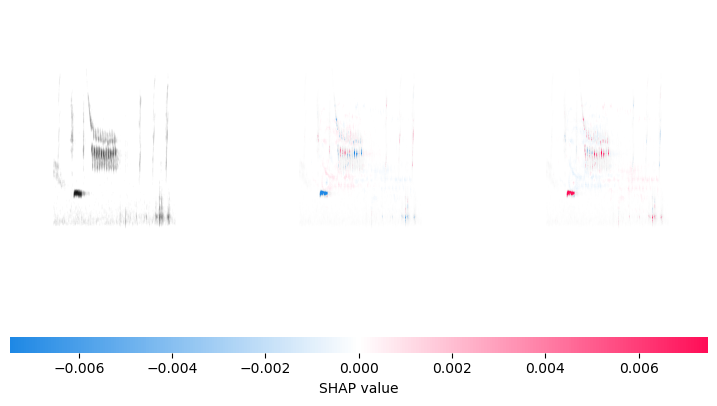

  0%|          | 0/100 [00:00<?, ?it/s]

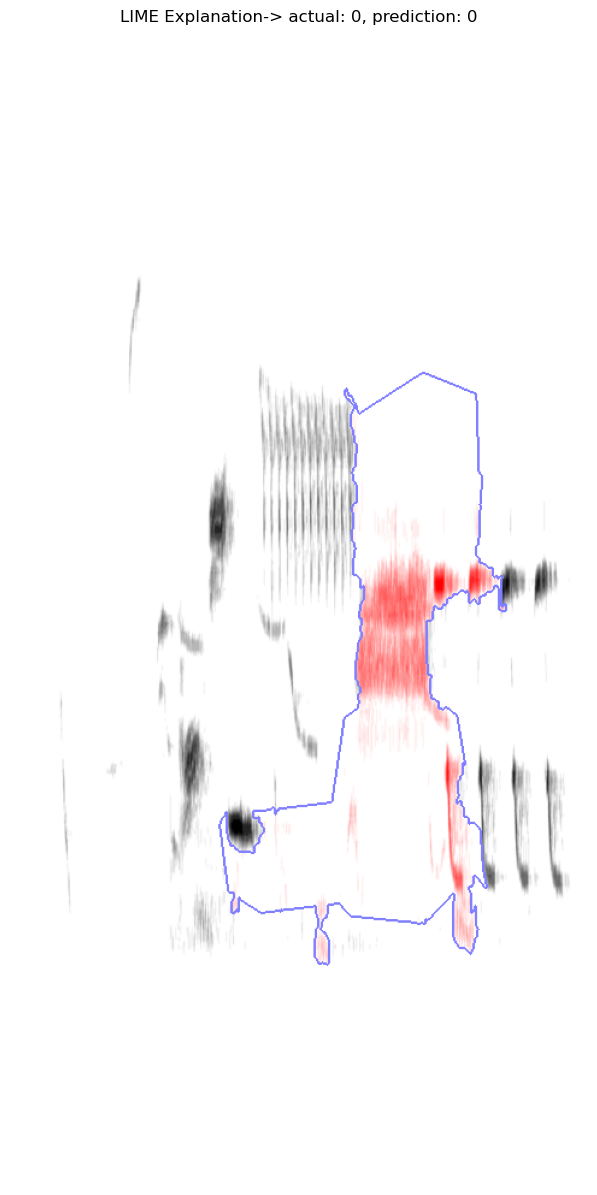

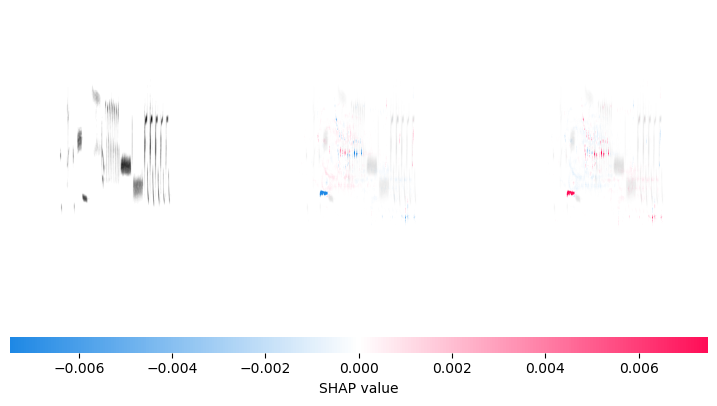

  0%|          | 0/100 [00:00<?, ?it/s]

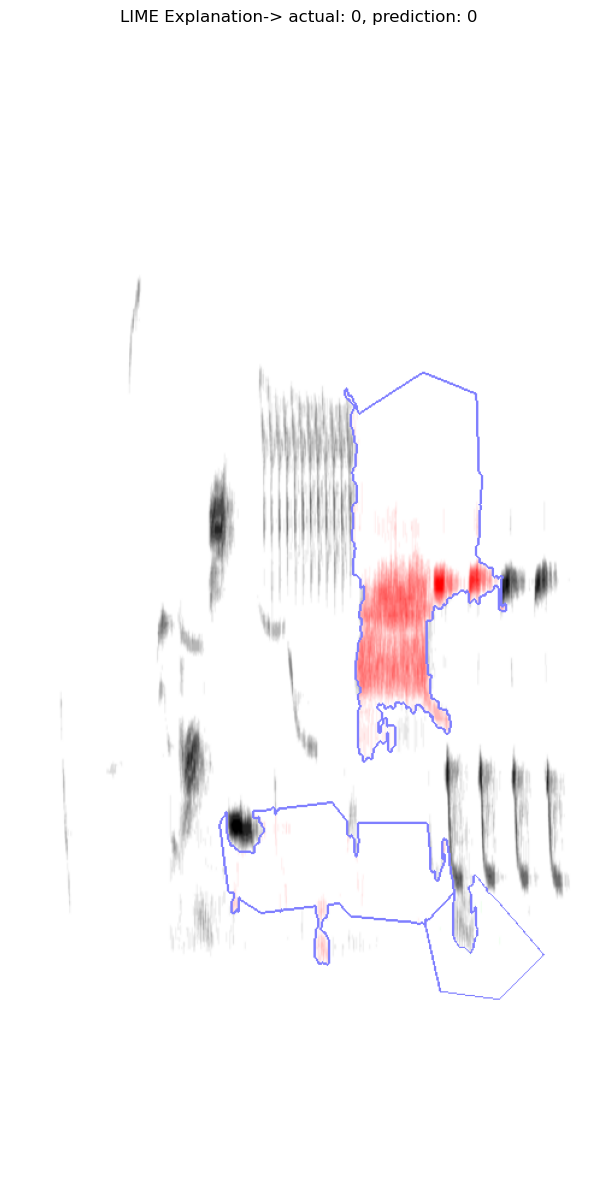

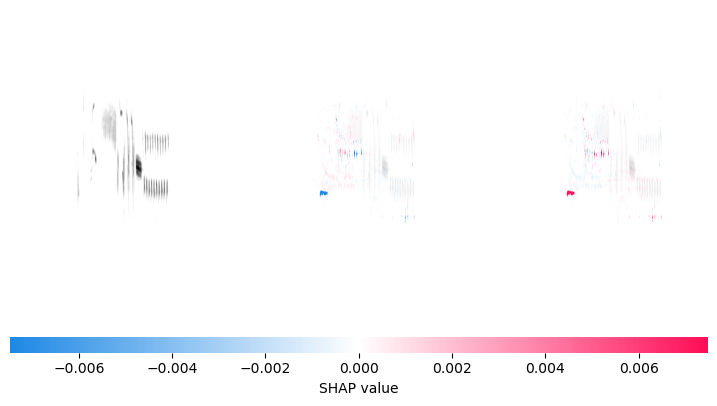

  0%|          | 0/100 [00:00<?, ?it/s]

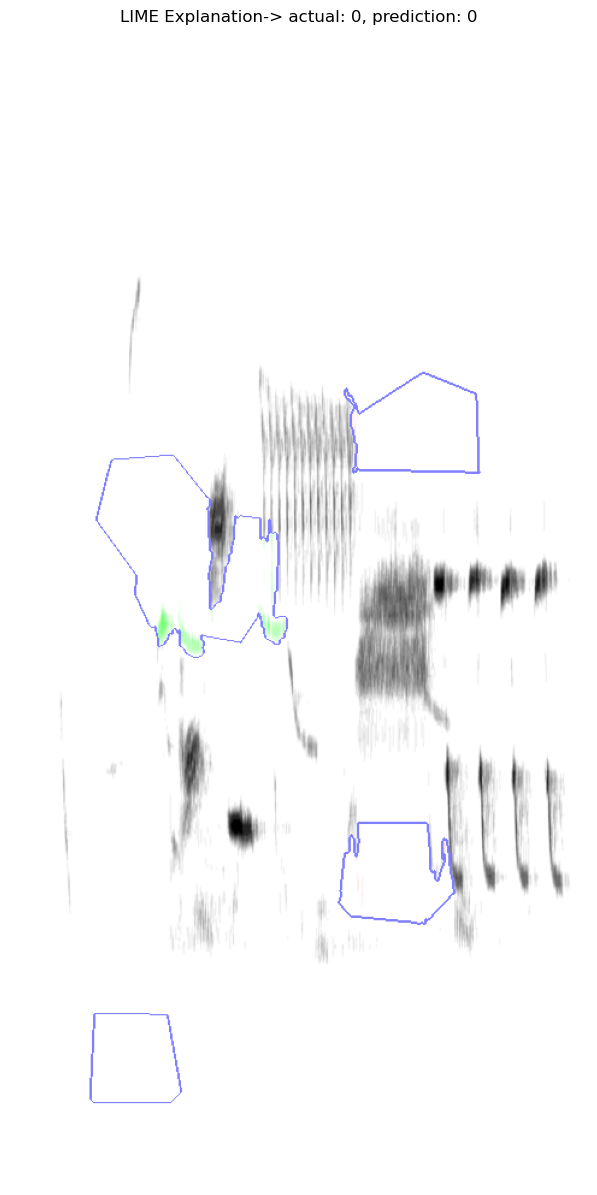

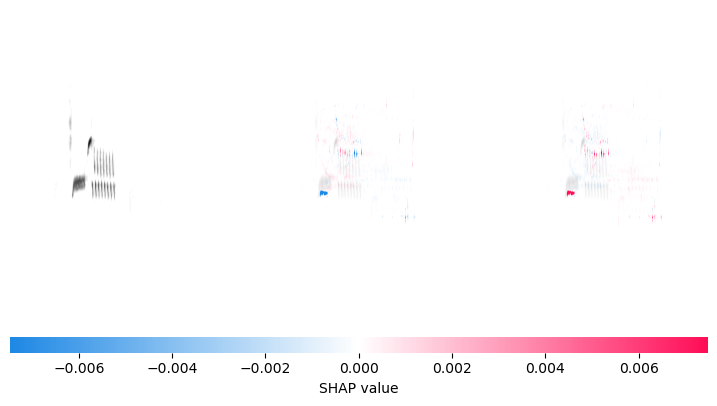

  0%|          | 0/100 [00:00<?, ?it/s]

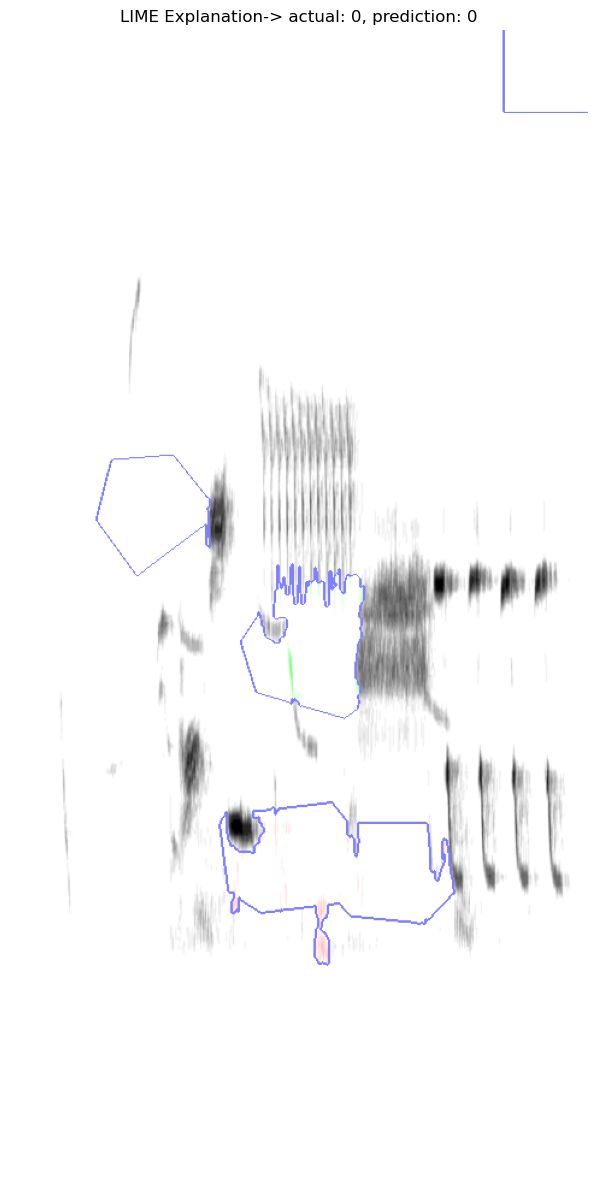

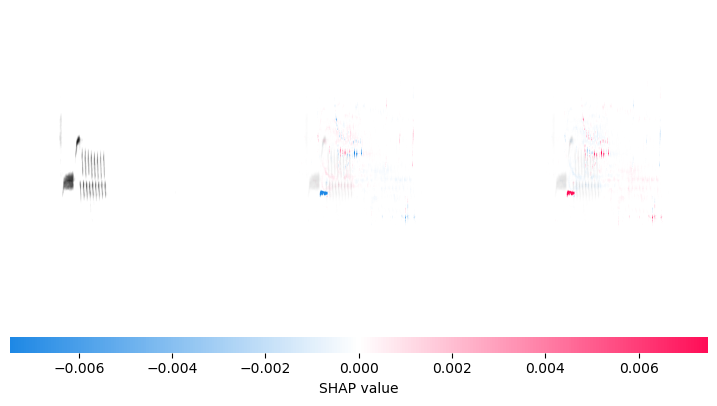

  0%|          | 0/100 [00:00<?, ?it/s]

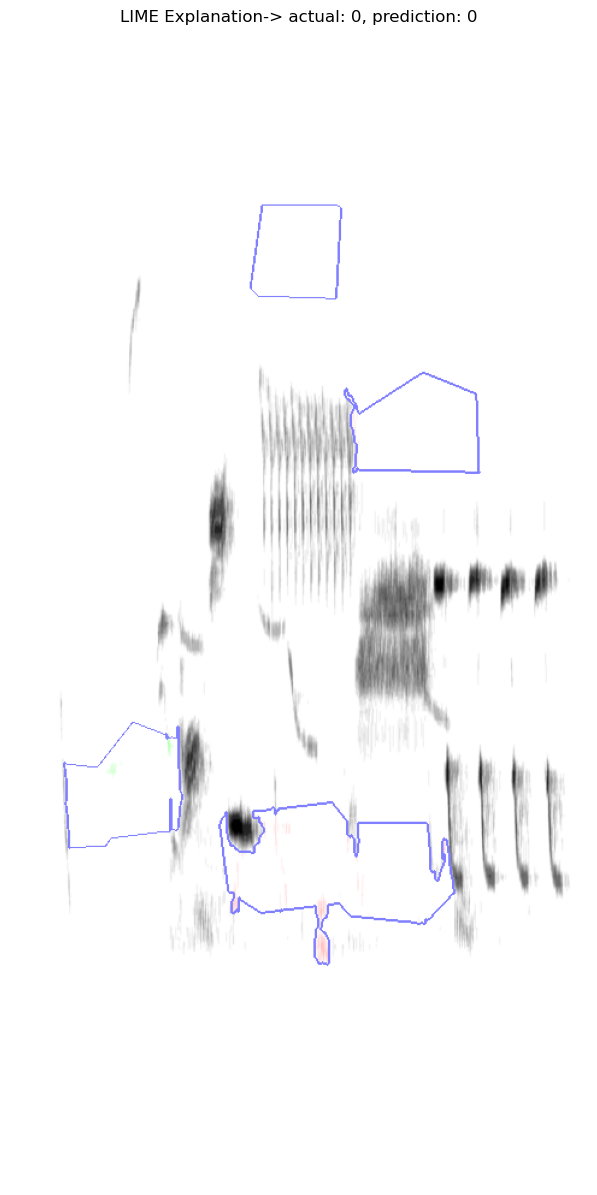

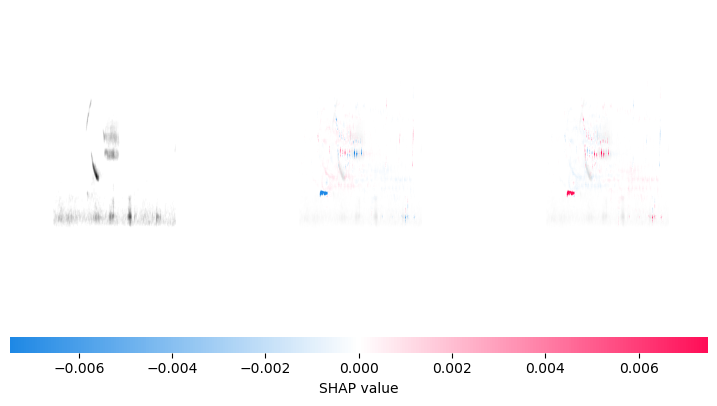

  0%|          | 0/100 [00:00<?, ?it/s]

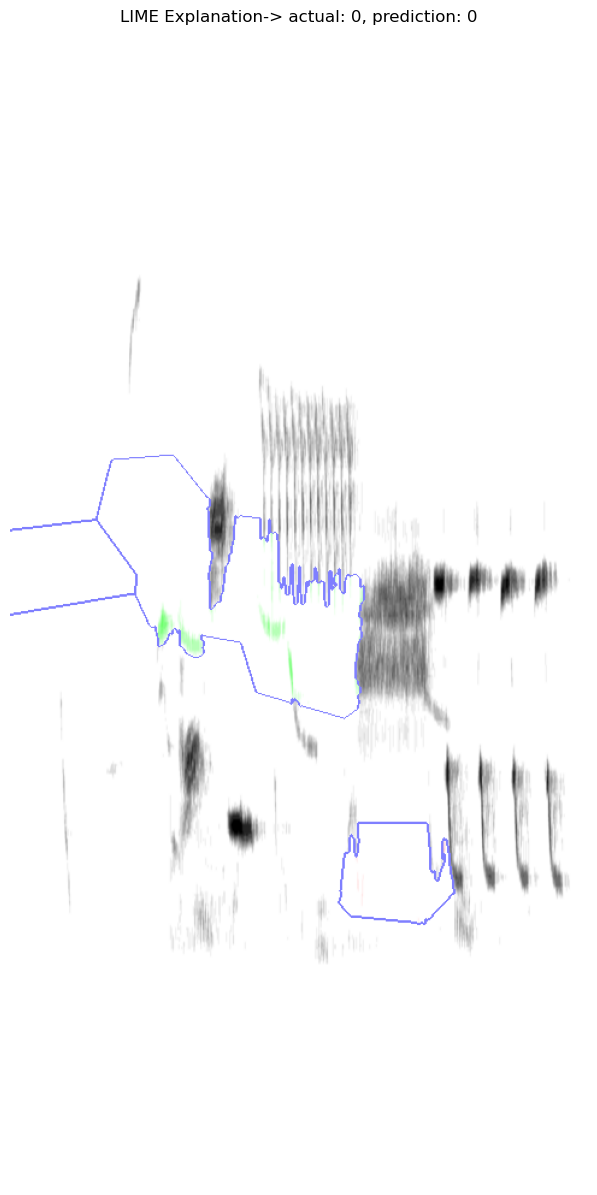

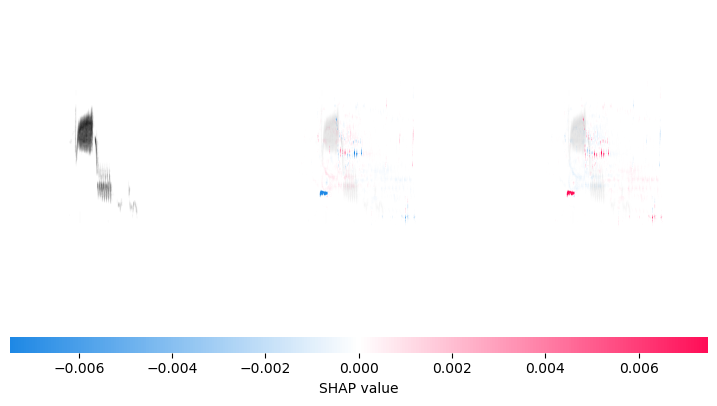

  0%|          | 0/100 [00:00<?, ?it/s]

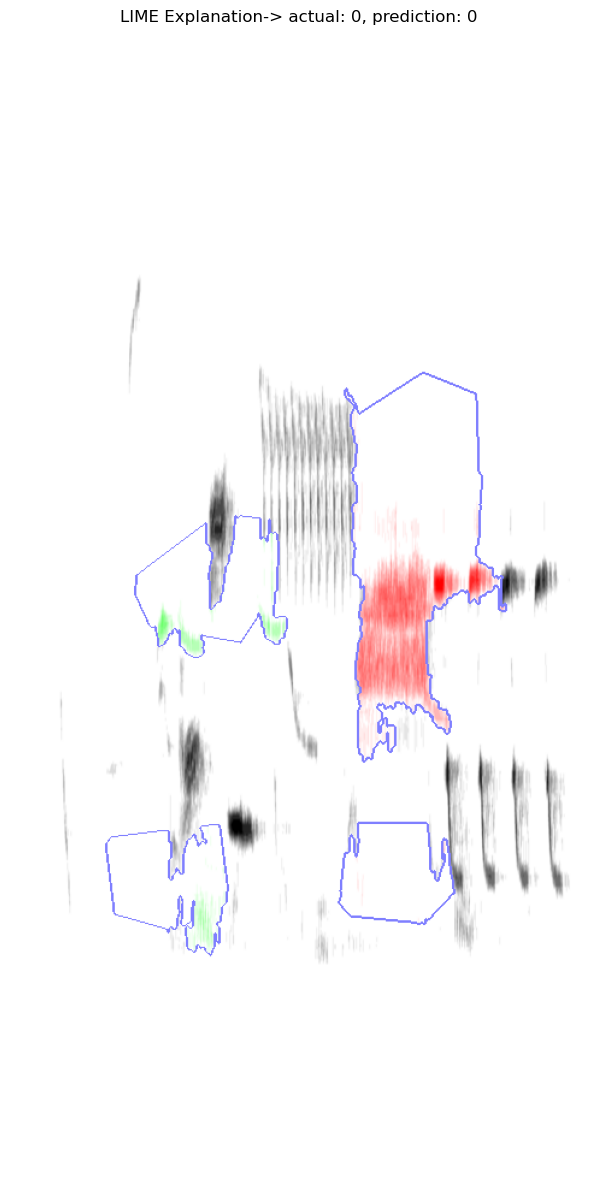

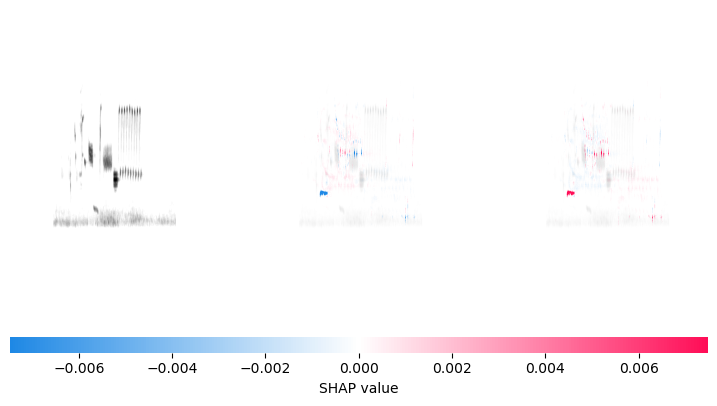

  0%|          | 0/100 [00:00<?, ?it/s]

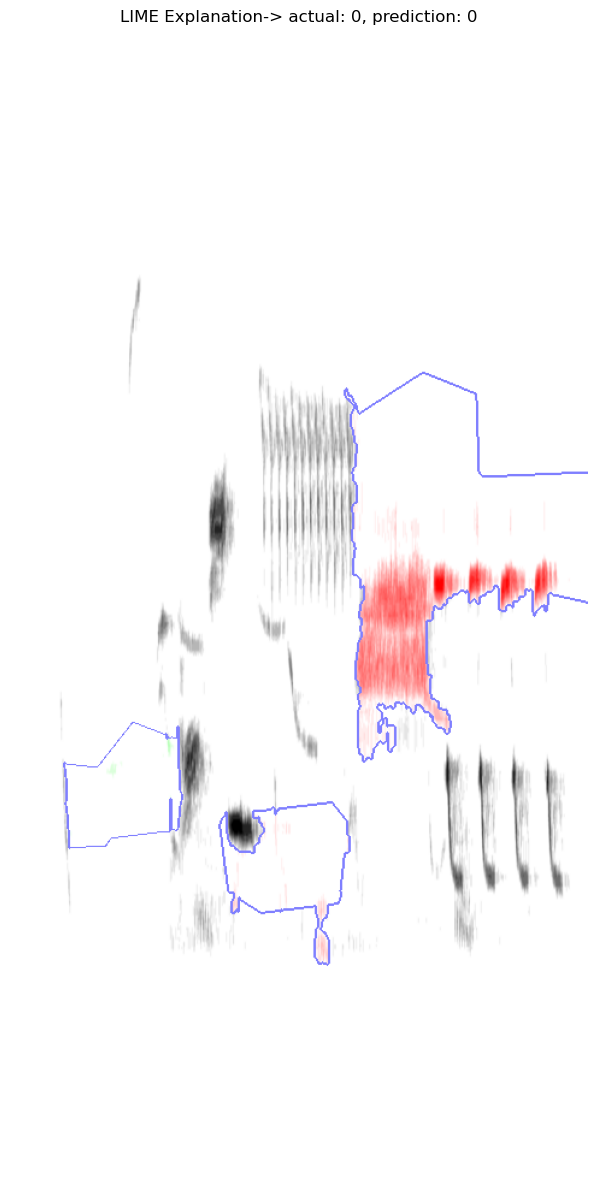

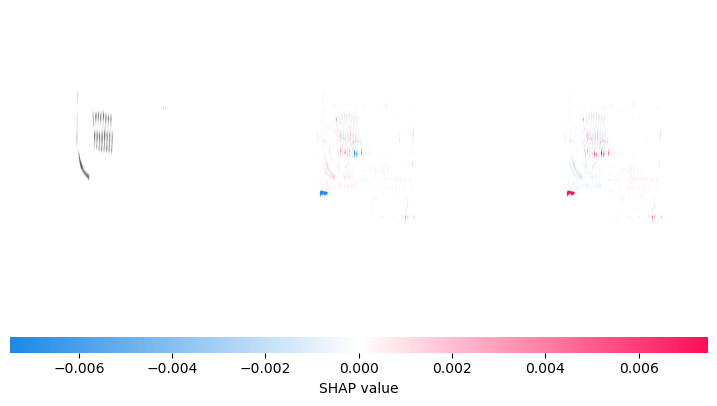

  0%|          | 0/100 [00:00<?, ?it/s]

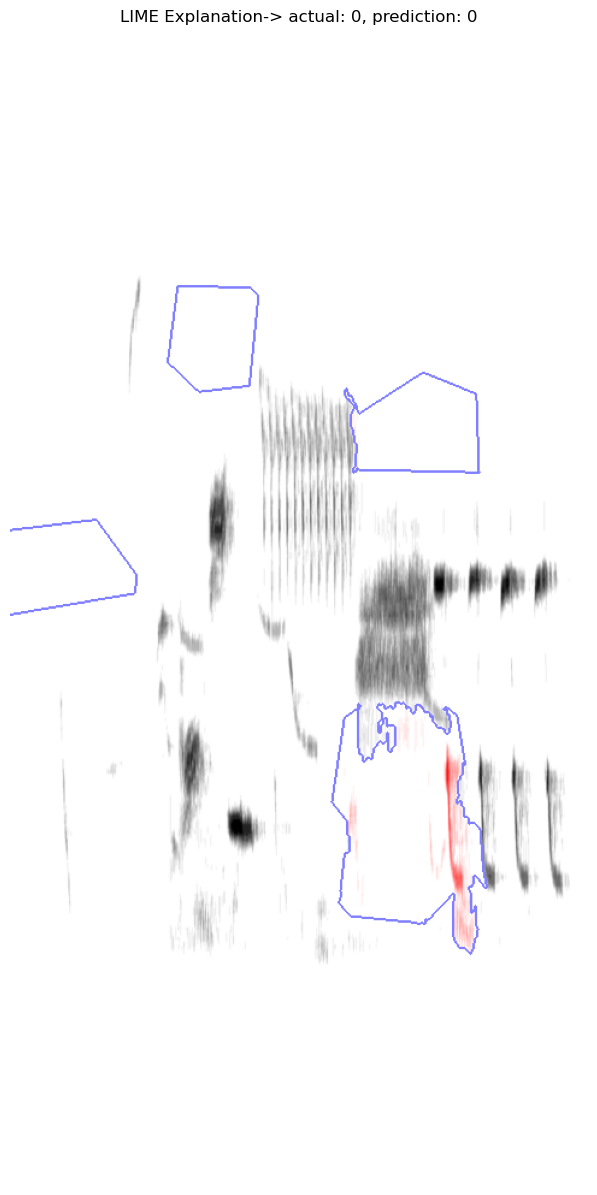

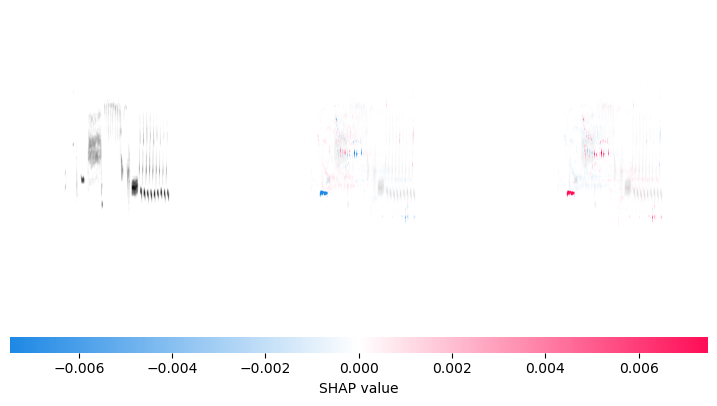

  0%|          | 0/100 [00:00<?, ?it/s]

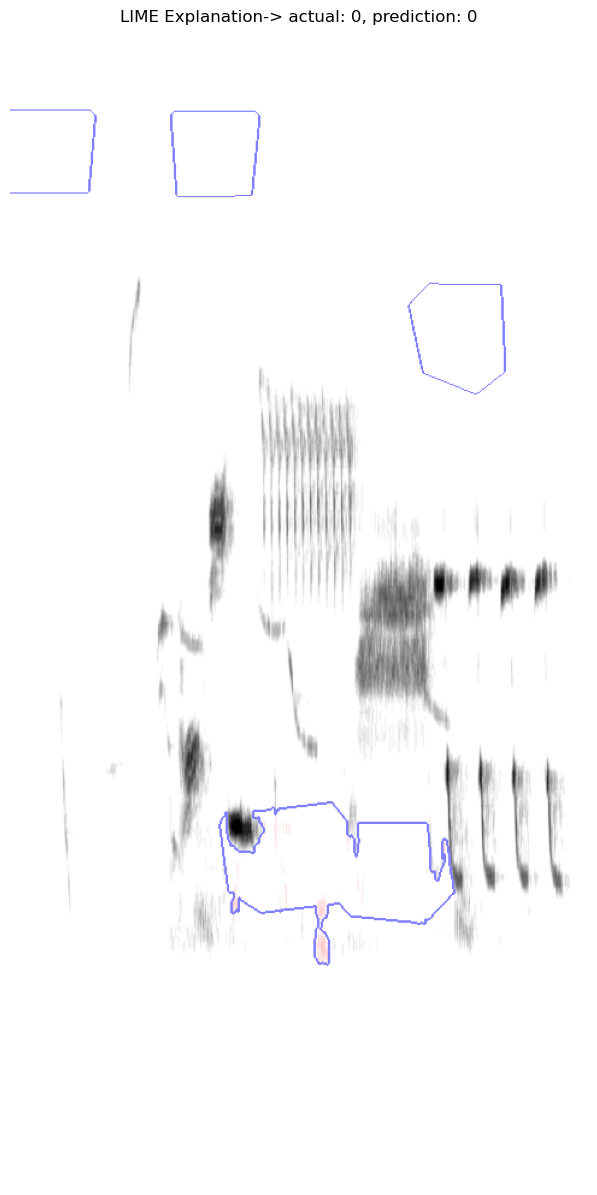

In [15]:
for i in range (10):
    ouptutForShap(shap_numpy, test_images[i])
    showLimeOutput(explainer, lime_cnn_model_wrapper, segmentation_fn, test_dataset[0])


In [ ]:
# Function to plot the loss and accuracy
def plot_metrics(train_loss_list, test_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, '-o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracy_list, '-o', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
# Plot loss and accuracy
plot_metrics(train_loss_list, test_accuracy_list)


In [ ]:
# Plot correct and incorrect predictions
def plot_images(images, labels, predictions, title, maxNumberOfImage):
    rows, cols = calculate_grid_size(maxNumberOfImage)
    plt.figure(figsize=(cols * 30, rows * 15))
    for i in range(maxNumberOfImage): # len(images)
        plt.subplot(rows, cols, i + 1)
        imshow(images[i])
        plt.title(f'Pred: {predictions[i]}, Actual: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Helper function to display images
def imshow(img):
    # img = img / 2 + 0.5  # Unnormalize the image
    # npimg = img.cpu().numpy()  # Ensure the tensor is on the CPU before displaying
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()  # Ensure the tensor is on the CPU before displaying
    npimg = npimg.squeeze()  # Remove the channel dimension (from (1, H, W) to (H, W))
    plt.imshow(npimg, cmap='gray')  # Display as a grayscale image
    
# Testing function that plots correct and incorrect predictions
def test_model_with_plots(model, test_loader, device='cpu', maxNumberOfImage = 9):
    model.eval()  # Set the model to evaluation mode
    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] == labels[i] :
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].item())
                    correct_preds.append(predicted[i].item())
                elif predicted[i] != labels[i] :
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].item())
                    incorrect_preds.append(predicted[i].item())

    print(f'Accuracy of the model on the test images: {100 * len(correct_images) / len(test_loader.dataset):.2f}%')
    # Plot correct predictions
    plot_images(correct_images, correct_labels, correct_preds, 'Correct Predictions', maxNumberOfImage)
    # Plot incorrect predictions
    plot_images(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions', maxNumberOfImage)


import math
def calculate_grid_size(n_images):
    cols = math.ceil(math.sqrt(n_images))  # Number of columns
    rows = math.ceil(n_images / cols)      # Number of rows based on columns
    return rows, cols

# Test the model and plot correct and incorrect predictions
test_model_with_plots(model, test_loader, device=device, maxNumberOfImage = 4)